In [1]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

จะมีการ re-id ใหม่ ก็ต่อเมื่อไม่เหมือนคนเก่าที่มีอยู่ -> id เดิม = คนเดิมเสมอ -> focus แค่ id ใหม่ที่เกินมาว่าจริงๆเป็น id เก่าเลขไหน

In [2]:
df = pd.read_csv("pose_data.csv")
df.head()

,video_name,frame_id,person_id,joint_id,x,y,score
0,Mek_Khara_Lor_Kaew,0,0,0,1567.591797,627.675171,0.972176
1,Mek_Khara_Lor_Kaew,0,0,1,1574.658691,620.556152,0.967867
2,Mek_Khara_Lor_Kaew,0,0,2,1564.053589,620.256836,0.765548
3,Mek_Khara_Lor_Kaew,0,0,3,1592.332397,623.721985,0.946861
4,Mek_Khara_Lor_Kaew,0,0,4,1563.698364,623.566528,0.185544


In [3]:
expected_ids = set(range(9))  # {0,1,2,3,4,5,6,7,8}

correct_frame_list = []
incorrect_frame_list = []
missing_main_id_frame_list = []

for frame_id in df['frame_id'].unique():
    person_id = set(df[df['frame_id'] == frame_id]['person_id'].unique())
    print(
        f"Frame id: {frame_id} - Person id list: "
        f"{sorted(int(pid) for pid in person_id)}"
    )

    if len(person_id) != 9:
        incorrect_frame_list.append(int(frame_id))
    elif person_id == expected_ids:
        correct_frame_list.append(int(frame_id))
    else:
        missing_main_id_frame_list.append(int(frame_id))

Frame id: 0 - Person id list: [0, 1, 2, 3, 4, 5, 6, 7, 8]
Frame id: 1 - Person id list: [0, 1, 2, 3, 4, 5, 6, 7, 8]
Frame id: 2 - Person id list: [0, 1, 2, 3, 4, 5, 6, 7, 8]
Frame id: 3 - Person id list: [0, 1, 2, 3, 4, 5, 6, 7, 8]
Frame id: 4 - Person id list: [0, 1, 2, 3, 4, 5, 6, 7, 8]
Frame id: 5 - Person id list: [0, 1, 2, 3, 4, 5, 6, 7, 8]
Frame id: 6 - Person id list: [0, 1, 2, 3, 4, 5, 6, 7, 8]
Frame id: 7 - Person id list: [0, 1, 2, 3, 4, 5, 6, 7, 8]
Frame id: 8 - Person id list: [0, 1, 2, 3, 4, 5, 6, 7, 8]
Frame id: 9 - Person id list: [0, 1, 2, 3, 4, 5, 6, 7, 8]
Frame id: 10 - Person id list: [0, 1, 2, 3, 4, 5, 6, 7, 8]
Frame id: 11 - Person id list: [0, 1, 2, 3, 4, 5, 6, 7, 8]
Frame id: 12 - Person id list: [0, 1, 2, 3, 4, 5, 6, 7, 8]
Frame id: 13 - Person id list: [0, 1, 2, 3, 4, 5, 6, 7, 8]
Frame id: 14 - Person id list: [0, 1, 2, 3, 4, 5, 6, 7, 8]
Frame id: 15 - Person id list: [0, 1, 2, 3, 4, 5, 6, 7, 8]
Frame id: 16 - Person id list: [0, 1, 2, 3, 4, 5, 6, 7, 8]
Frame i

In [4]:
len(correct_frame_list)

665

In [5]:
len(incorrect_frame_list)

146

In [6]:
len(missing_main_id_frame_list)

0

แสดงว่ามีแค่เคสที่ detect บางส่วนของคนนั้นเป็น id ใหม่ ไม่มี id ใหม่จริงๆ -> ถ้า re-id ต้องมีบาง id หลักหายไป

ดังนั้นต้องหาจาก skeleton ว่าจุด id ไหนไม่ครบทุกส่วน

yolov8l-pose.pt

โมเดลนี้ใช้ COCO-Keypoints

➡️ 17 joints ต่อคน แบบ fix

0  nose

1  left_eye

2  right_eye

3  left_ear

4  right_ear

5  left_shoulder

6  right_shoulder

7  left_elbow

8  right_elbow

9  left_wrist

10 right_wrist

11 left_hip

12 right_hip

13 left_knee

14 right_knee

15 left_ankle

16 right_ankle

In [7]:
EXPECTED_JOINT_IDS = set(range(17))

In [8]:
pose_status = (
    df
    .groupby(['video_name', 'frame_id', 'person_id'])['joint_id']
    .apply(lambda x: EXPECTED_JOINT_IDS - set(x))
    .reset_index(name='missing_joints')
)

# เอาเฉพาะที่ขาดจริง
pose_status = pose_status[pose_status['missing_joints'].map(len) > 0]


In [9]:
len(pose_status)

0

ID ที่เกินมา ไม่ใช่ pose ขาด เพราะมีจุดครบทุก id

ดังนั้น

| สมมติฐาน                      | ผลลัพธ์               |
| ----------------------------- | --------------------- |
| part detection (joint ขาด)    | ❌ ไม่ใช่              |
| re-id (id switch)             | ❌ ไม่เห็นสัญญาณ       |
| duplicate full-body detection | ✅ **เป็นไปได้สูงมาก** |

YOLOv8 detect คนเดียวซ้ำ 2 กล่อง
แต่ทั้งสองกล่องมี pose ครบ


ทำไม YOLOv8-pose ทำแบบนี้ได้?

YOLOv8-pose:

predict keypoints จาก bbox

ถ้า bbox ซ้อนกัน → model สามารถให้ pose ครบทั้งสองอัน

โดยไม่รู้ว่าคือคนเดียวกัน

Tracker จึง:

สร้าง person_id ใหม่

ทั้งที่ไม่มีคนใหม่จริง

❌ อย่าตัด ID ที่เกินทิ้งทันที
✅ แต่ สามารถตัดได้อย่างมีเงื่อนไขและปลอดภัย

เดี๋ยวอธิบายให้ชัดว่าทำ เมื่อไหร่, อย่างไร, และ อะไรห้ามทำ

ทำไม “ตัดทิ้งทันที” ถึงเสี่ยง ❌

แม้จะเป็น duplicate จริง แต่:

แต่ละ bbox อาจเห็น joint คนละจุด

กล่อง A เห็นแขนชัด

กล่อง B เห็นขาชัด

ถ้าทิ้งอันหนึ่ง → pose เสีย

confidence ต่อ joint ไม่เท่ากัน

joint เดียวกัน แต่ score ต่าง

ทิ้ง = ทิ้งข้อมูลดีไป

บางเฟรม duplicate = transition

เฟรมถัดไปอาจเหลือ ID เดียว

ถ้าลบทิ้งเร็วไป → ID กระโดด

แนวทางที่ “ถูกต้องกว่า” (แนะนำ)

ไม่ลบทิ้ง แต่ “merge แล้วเลือกตัวแทน”

In [10]:
import numpy as np

def pose_distance(pose_a, pose_b):
    """
    pose_a, pose_b: DataFrame ของ person_id เดียว (joint_id, x, y)
    return: mean Euclidean distance
    """
    merged = pose_a.merge(
        pose_b,
        on='joint_id',
        suffixes=('_a', '_b')
    )
    dist = np.sqrt(
        (merged['x_a'] - merged['x_b'])**2 +
        (merged['y_a'] - merged['y_b'])**2
    )
    return dist.mean()


In [11]:
merge_log = []

In [12]:
def merge_two_persons(pose_a, pose_b, keep_person_id):
    """
    merge pose_a และ pose_b โดยเลือก joint ที่ score สูงกว่า
    keep_person_id: person_id ที่จะเก็บไว้
    """
    merged = pose_a.merge(
        pose_b,
        on=['joint_id', 'frame_id', 'video_name'],
        suffixes=('_a', '_b')
    )

    use_a = merged['score_a'] >= merged['score_b']

    merged_pose = merged[['video_name', 'frame_id', 'joint_id']].copy()
    merged_pose['person_id'] = keep_person_id

    merged_pose['x'] = np.where(use_a, merged['x_a'], merged['x_b'])
    merged_pose['y'] = np.where(use_a, merged['y_a'], merged['y_b'])
    merged_pose['score'] = np.where(use_a, merged['score_a'], merged['score_b'])

    return merged_pose


จากโค้ด:

video_stream = yt.streams.filter(
    file_extension='mp4',
    only_video=True
).order_by('resolution').desc().first()


แปลว่า:

ได้ resolution สูงสุดที่มีใน YouTube

สำหรับคลิปมวยไทยแบบนี้ → ส่วนใหญ่คือ 1080p (1920×1080)
บางที 720p แต่ไม่ต่ำกว่านี้

ใน YOLOv8-pose:

keypoint error ปกติ ≈ 5–15 px

duplicate full-body pose:

mean keypoint distance ≈ 5–25 px

คนคนละคน:

mean distance ≈ 60–150+ px

👉 30 px = เส้นแบ่งที่ปลอดภัย

| Resolution | dist_thresh |
| ---------- | ----------- |
| 720p       | 20–25       |
| **1080p**  | **30–35** ⭐ |
| 1440p      | 40–50       |
| 4K         | 60–80       |


In [13]:
def merge_duplicates_in_frame(df_frame, dist_thresh=30):
    """
    df_frame: df ของ frame เดียว
    return: df หลัง merge duplicate
    """
    persons = list(df_frame['person_id'].unique())
    used = set()
    result = []

    for i, pid_a in enumerate(persons):
        if pid_a in used:
            continue

        pose_a = df_frame[df_frame['person_id'] == pid_a]

        merged_pose = pose_a
        used.add(pid_a)

        for pid_b in persons[i+1:]:
            if pid_b in used:
                continue

            pose_b = df_frame[df_frame['person_id'] == pid_b]
            dist = pose_distance(pose_a, pose_b)

            if dist < dist_thresh:
                merge_log.append({
                    'video_name': df_frame['video_name'].iloc[0],
                    'frame_id': df_frame['frame_id'].iloc[0],
                    'from_id': pid_b,
                    'to_id': pid_a,
                    'distance': dist,
                    'reason': 'duplicate'
                })
                
                # duplicate → merge
                merged_pose = merge_two_persons(
                    merged_pose,
                    pose_b,
                    keep_person_id=pid_a
                )
                used.add(pid_b)

        result.append(merged_pose)

    return pd.concat(result, ignore_index=True)


In [14]:
merged_df = (
    df
    .groupby(['video_name', 'frame_id'], group_keys=False)
    .apply(merge_duplicates_in_frame)
)


C:\Users\User\AppData\Local\Temp\ipykernel_11696\1132012302.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(merge_duplicates_in_frame)


In [15]:
expected_ids = set(range(9))  # {0,1,2,3,4,5,6,7,8}

correct_frame_list = []
incorrect_frame_list = []
missing_main_id_frame_list = []

for frame_id in merged_df['frame_id'].unique():
    person_id = set(merged_df[merged_df['frame_id'] == frame_id]['person_id'].unique())
    print(
        f"Frame id: {frame_id} - Person id list: "
        f"{sorted(int(pid) for pid in person_id)}"
    )

    if len(person_id) != 9:
        incorrect_frame_list.append(int(frame_id))
    elif person_id == expected_ids:
        correct_frame_list.append(int(frame_id))
    else:
        missing_main_id_frame_list.append(int(frame_id))

Frame id: 0 - Person id list: [0, 1, 2, 3, 4, 5, 6, 7, 8]
Frame id: 1 - Person id list: [0, 1, 2, 3, 4, 5, 6, 7, 8]
Frame id: 2 - Person id list: [0, 1, 2, 3, 4, 5, 6, 7, 8]
Frame id: 3 - Person id list: [0, 1, 2, 3, 4, 5, 6, 7, 8]
Frame id: 4 - Person id list: [0, 1, 2, 3, 4, 5, 6, 7, 8]
Frame id: 5 - Person id list: [0, 1, 2, 3, 4, 5, 6, 7, 8]
Frame id: 6 - Person id list: [0, 1, 2, 3, 4, 5, 6, 7, 8]
Frame id: 7 - Person id list: [0, 1, 2, 3, 4, 5, 6, 7, 8]
Frame id: 8 - Person id list: [0, 1, 2, 3, 4, 5, 6, 7, 8]
Frame id: 9 - Person id list: [0, 1, 2, 3, 4, 5, 6, 7, 8]
Frame id: 10 - Person id list: [0, 1, 2, 3, 4, 5, 6, 7, 8]
Frame id: 11 - Person id list: [0, 1, 2, 3, 4, 5, 6, 7, 8]
Frame id: 12 - Person id list: [0, 1, 2, 3, 4, 5, 6, 7, 8]
Frame id: 13 - Person id list: [0, 1, 2, 3, 4, 5, 6, 7, 8]
Frame id: 14 - Person id list: [0, 1, 2, 3, 4, 5, 6, 7, 8]
Frame id: 15 - Person id list: [0, 1, 2, 3, 4, 5, 6, 7, 8]
Frame id: 16 - Person id list: [0, 1, 2, 3, 4, 5, 6, 7, 8]
Frame i

In [16]:
len(correct_frame_list)

803

In [17]:
len(incorrect_frame_list)

8

In [18]:
len(missing_main_id_frame_list)

0

In [19]:
lifespan = (
    merged_df
    .groupby('person_id')['frame_id']
    .nunique()
)

lifespan

person_id
0     811
1     811
2     811
3     811
4     811
5     811
6     811
7     811
8     811
9       7
10      1
Name: frame_id, dtype: int64

อ่านค่า lifespan

person_id | #frames
-------------------
0–8       | 811   ← อยู่ครบทั้งคลิป
9         | 7     ← โผล่สั้น ๆ
10        | 1     ← โผล่เฟรมเดียว

แปลความหมาย

ID 0–8
→ คนจริง 9 คน (stable track)

ID 9 (7 เฟรม)
→ duplicate / noise เกือบแน่นอน

ID 10 (1 เฟรม)
→ false positive 100%

👉 ไม่มีสัญญาณ re-id เลย

👉 tracker ทำงานถูกต้องมาก

ถ้า person_id มี lifespan < 10 เฟรม

→ ถือว่าเป็น duplicate

→ merge เข้ากับ ID หลักที่ใกล้ที่สุด


In [20]:
BAD_IDS = lifespan[lifespan < 10].index.tolist()

In [21]:
def merge_short_lived_ids(df, bad_ids, dist_thresh=40):
    frames = []

    for (v, f), df_frame in df.groupby(['video_name', 'frame_id']):
        bad_in_frame = set(df_frame['person_id']) & set(bad_ids)

        if not bad_in_frame:
            frames.append(df_frame)
            continue

        good_ids = set(df_frame['person_id']) - bad_in_frame
        result = df_frame[df_frame['person_id'].isin(good_ids)].copy()

        for bad_id in bad_in_frame:
            pose_bad = df_frame[df_frame['person_id'] == bad_id]

            # หา good id ที่ใกล้ที่สุด
            dists = []
            for gid in good_ids:
                pose_good = df_frame[df_frame['person_id'] == gid]
                dists.append((gid, pose_distance(pose_bad, pose_good)))

            best_gid, best_dist = min(dists, key=lambda x: x[1])

            if best_dist < dist_thresh:
                merge_log.append({
                    'video_name': v,
                    'frame_id': f,
                    'from_id': bad_id,
                    'to_id': best_gid,
                    'distance': best_dist,
                    'reason': 'short_lived'
                })

                merged_pose = merge_two_persons(
                    pose_bad,
                    df_frame[df_frame['person_id'] == best_gid],
                    keep_person_id=best_gid
                )
                result = result[result['person_id'] != best_gid]
                result = pd.concat([result, merged_pose])
            # ถ้าไม่ใกล้ → ทิ้ง bad_id ไปเลย (noise)

        frames.append(result)

    return pd.concat(frames, ignore_index=True)


In [22]:
clean_df = merge_short_lived_ids(merged_df, BAD_IDS)
clean_df.head()

,video_name,frame_id,person_id,joint_id,x,y,score
0,Hoang_Hearn,0,0,0,257.707092,629.240845,0.171782
1,Hoang_Hearn,0,0,1,260.629639,621.918457,0.159820
2,Hoang_Hearn,0,0,2,258.474365,621.872253,0.032368
3,Hoang_Hearn,0,0,3,264.950623,621.193115,0.924104
4,Hoang_Hearn,0,0,4,286.588562,618.743774,0.355051


In [23]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 561272 entries, 0 to 561271
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   video_name  561272 non-null  object 
 1   frame_id    561272 non-null  int64  
 2   person_id   561272 non-null  int64  
 3   joint_id    561272 non-null  int64  
 4   x           561272 non-null  float64
 5   y           561272 non-null  float64
 6   score       561272 non-null  float64
dtypes: float64(3), int64(3), object(1)
memory usage: 30.0+ MB


In [24]:
expected_ids = set(range(9))  # {0,1,2,3,4,5,6,7,8}

correct_frame_list = []
incorrect_frame_list = []
missing_main_id_frame_list = []

for frame_id in clean_df['frame_id'].unique():
    person_id = set(clean_df[clean_df['frame_id'] == frame_id]['person_id'].unique())
    print(
        f"Frame id: {frame_id} - Person id list: "
        f"{sorted(int(pid) for pid in person_id)}"
    )

    if len(person_id) != 9:
        incorrect_frame_list.append(int(frame_id))
    elif person_id == expected_ids:
        correct_frame_list.append(int(frame_id))
    else:
        missing_main_id_frame_list.append(int(frame_id))

Frame id: 0 - Person id list: [0, 1, 2, 3, 4, 5, 6, 7, 8]
Frame id: 1 - Person id list: [0, 1, 2, 3, 4, 5, 6, 7, 8]
Frame id: 2 - Person id list: [0, 1, 2, 3, 4, 5, 6, 7, 8]
Frame id: 3 - Person id list: [0, 1, 2, 3, 4, 5, 6, 7, 8]
Frame id: 4 - Person id list: [0, 1, 2, 3, 4, 5, 6, 7, 8]
Frame id: 5 - Person id list: [0, 1, 2, 3, 4, 5, 6, 7, 8]
Frame id: 6 - Person id list: [0, 1, 2, 3, 4, 5, 6, 7, 8]
Frame id: 7 - Person id list: [0, 1, 2, 3, 4, 5, 6, 7, 8]
Frame id: 8 - Person id list: [0, 1, 2, 3, 4, 5, 6, 7, 8]
Frame id: 9 - Person id list: [0, 1, 2, 3, 4, 5, 6, 7, 8]
Frame id: 10 - Person id list: [0, 1, 2, 3, 4, 5, 6, 7, 8]
Frame id: 11 - Person id list: [0, 1, 2, 3, 4, 5, 6, 7, 8]
Frame id: 12 - Person id list: [0, 1, 2, 3, 4, 5, 6, 7, 8]
Frame id: 13 - Person id list: [0, 1, 2, 3, 4, 5, 6, 7, 8]
Frame id: 14 - Person id list: [0, 1, 2, 3, 4, 5, 6, 7, 8]
Frame id: 15 - Person id list: [0, 1, 2, 3, 4, 5, 6, 7, 8]
Frame id: 16 - Person id list: [0, 1, 2, 3, 4, 5, 6, 7, 8]
Frame i

In [25]:
len(correct_frame_list)

811

In [26]:
len(incorrect_frame_list)

0

In [27]:
len(missing_main_id_frame_list)

0

In [28]:
clean_df.to_csv("cleaned_pose_data.csv", index=False)

In [29]:
merge_log_df = pd.DataFrame(merge_log)
merge_log_df.to_csv("merged_log.csv", index=False)

In [30]:
merge_log_df

,video_name,frame_id,from_id,to_id,distance,reason
0,Hoang_Hearn,116,9,8,4.825730,duplicate
1,Hoang_Hearn,117,9,8,6.421395,duplicate
2,Hoang_Hearn,118,9,8,5.948162,duplicate
3,Hoang_Hearn,119,9,8,6.591106,duplicate
4,Hoang_Hearn,120,9,8,6.979741,duplicate
...,...,...,...,...,...,...
153,Phra_Ram_Phang_Sorn,180,9,6,17.515705,duplicate
154,Phra_Ram_Phang_Sorn,187,9,3,13.013495,duplicate
155,Phra_Ram_Phang_Sorn,188,9,7,13.480463,duplicate
156,Phra_Ram_Phang_Sorn,309,9,8,6.108857,duplicate


In [52]:
merge_log_df['reason'].unique()

array(['duplicate'], dtype=object)

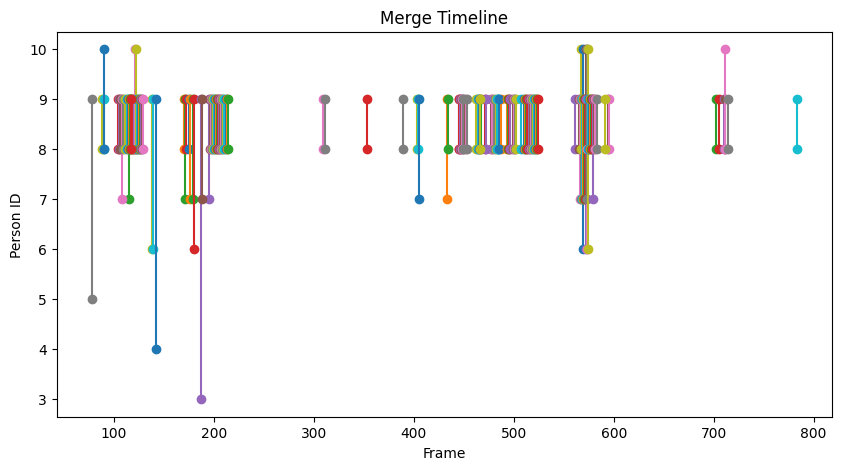

In [32]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 5))

for _, r in merge_log_df.iterrows():
    ax.plot(
        [r['frame_id'], r['frame_id']],
        [r['from_id'], r['to_id']],
        marker='o'
    )

ax.set_xlabel("Frame")
ax.set_ylabel("Person ID")
ax.set_title("Merge Timeline")
plt.show()


มีบาง bad_id ที่ “หายไปจากผลลัพธ์” แต่ ไม่ได้เข้าเงื่อนไข best_dist < dist_thresh

⇒ เลย ถูกทิ้ง (noise) ไม่ได้ merge

⇒ จึง ไม่ถูก log


✅ best_dist < dist_thresh

→ merge + log

❌ best_dist >= dist_thresh

→ bad_id หายไป

→ ❌ ไม่ log อะไรเลย


In [33]:
flow = (
    merge_log_df
    .groupby(['from_id', 'to_id'])
    .size()
    .reset_index(name='count')
)


In [43]:
flow

,from_id,to_id,count
0,8,6,1
1,9,3,1
2,9,4,1
3,9,5,1
4,9,6,4
5,9,7,16
6,9,8,125
7,10,6,2
8,10,7,2
9,10,8,5


id ที่ไม่มีการ merged เข้า id ตัวเอง (to_id) และถูก merged ไป id อื่น (from_id) -> การ tracking pose ถูกต้องทุก skeleton เหมาะกับการเลือกเป็น train set

id: 0, 1, 2

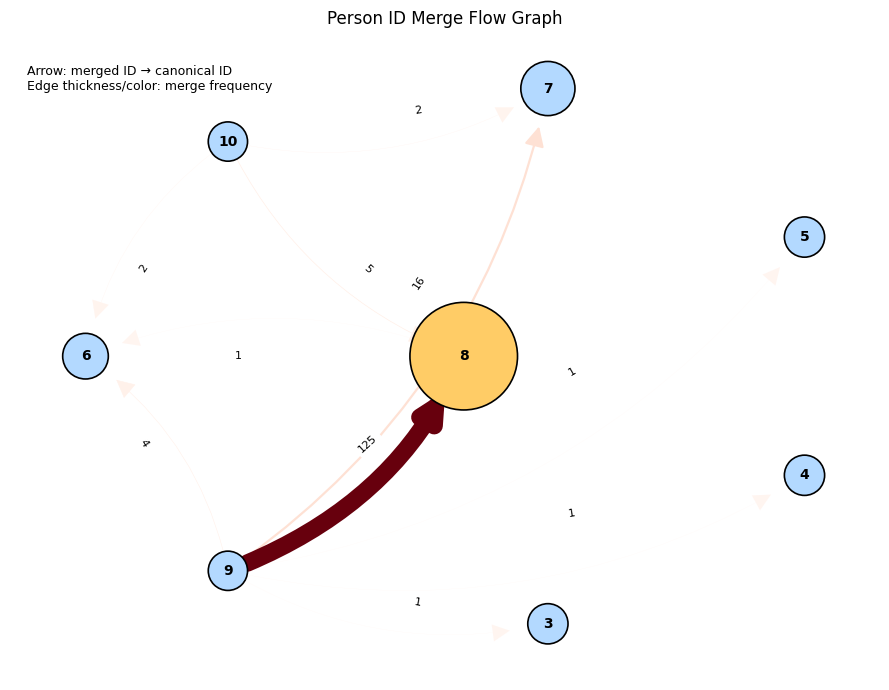

In [54]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph()

for _, r in flow.iterrows():
    G.add_edge(
        r['from_id'],
        r['to_id'],
        count=r['count']
    )

in_flow = {}
for u, v, d in G.edges(data=True):
    in_flow[v] = in_flow.get(v, 0) + d['count']

canonical_id = max(in_flow, key=in_flow.get)

others = [n for n in G.nodes() if n != canonical_id]
pos = nx.shell_layout(G, nlist=[[canonical_id], others])

node_sizes = [
    800 + 40 * in_flow.get(n, 0)
    for n in G.nodes()
]

node_colors = [
    "#ffcc66" if n == canonical_id else "#b3d9ff"
    for n in G.nodes()
]

edge_counts = [G[u][v]['count'] for u, v in G.edges()]

plt.figure(figsize=(9, 7))

nx.draw_networkx_nodes(
    G, pos,
    node_size=node_sizes,
    node_color=node_colors,
    edgecolors="black",
    linewidths=1.2
)

nx.draw_networkx_edges(
    G, pos,
    arrowstyle='-|>',
    arrowsize=30,
    width=[c / 10 for c in edge_counts],
    edge_color=edge_counts,
    edge_cmap=plt.cm.Reds,
    min_source_margin=15,
    min_target_margin=28,
    connectionstyle="arc3,rad=0.2"
)

nx.draw_networkx_labels(
    G, pos,
    font_size=10,
    font_weight="bold"
)

edge_labels = {
    (u, v): f"{G[u][v]['count']}"
    for u, v in G.edges()
}

nx.draw_networkx_edge_labels(
    G, pos,
    edge_labels=edge_labels,
    font_size=8,
    label_pos=0.6
)

plt.text(
    0.02, 0.95,
    "Arrow: merged ID → canonical ID\n"
    "Edge thickness/color: merge frequency",
    transform=plt.gca().transAxes,
    fontsize=9,
    verticalalignment="top"
)

plt.title("Person ID Merge Flow Graph")
plt.axis("off")
plt.tight_layout()
plt.show()


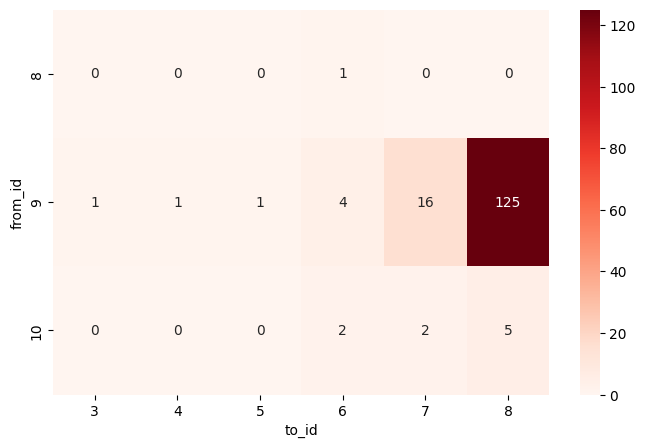

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt

pivot = flow.pivot(index="from_id", columns="to_id", values="count").fillna(0)

plt.figure(figsize=(8,5))
sns.heatmap(pivot, annot=True, fmt=".0f", cmap="Reds")
plt.show()

<Axes: xlabel='from_id'>

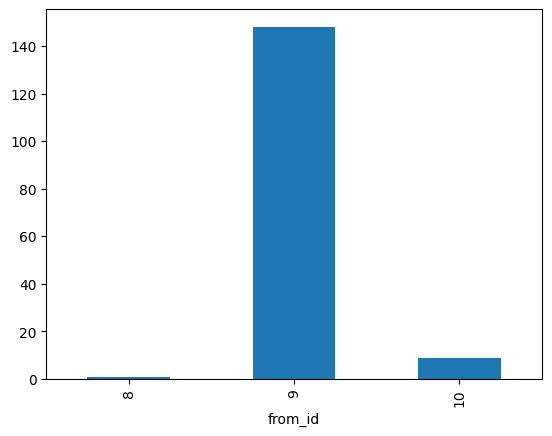

In [48]:
flow.groupby("from_id")["count"].sum().plot(kind="bar")


In [42]:
parent = dict(zip(merge_log_df['from_id'], merge_log_df['to_id']))

def find_root(x):
    while x in parent:
        x = parent[x]
    return x

final_map = {
    pid: find_root(pid)
    for pid in set(parent.keys()).union(parent.values())
}


In [44]:
final_map

{8: 6, 9: 6, 10: 6, 6: 6}